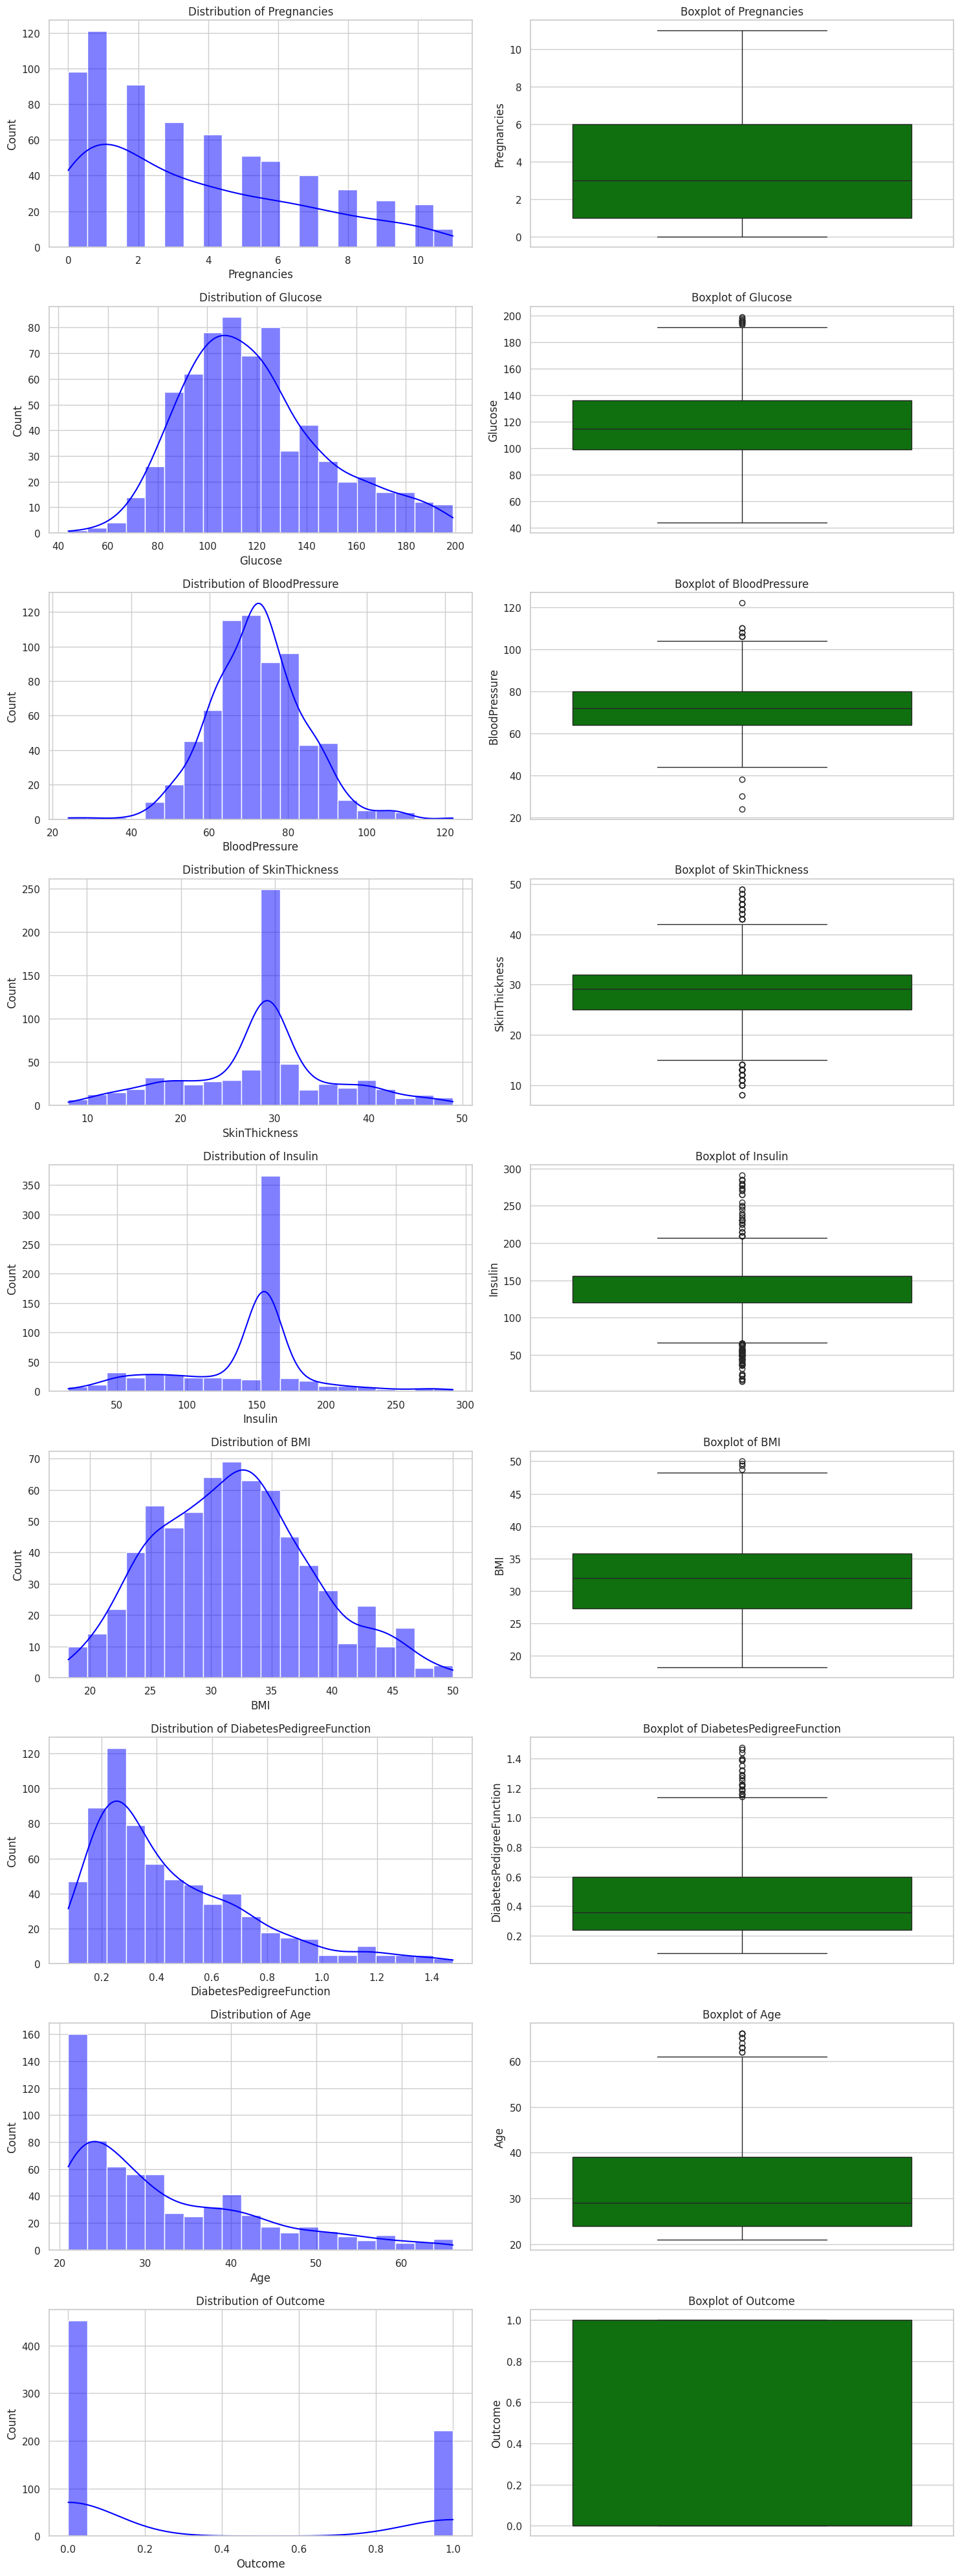

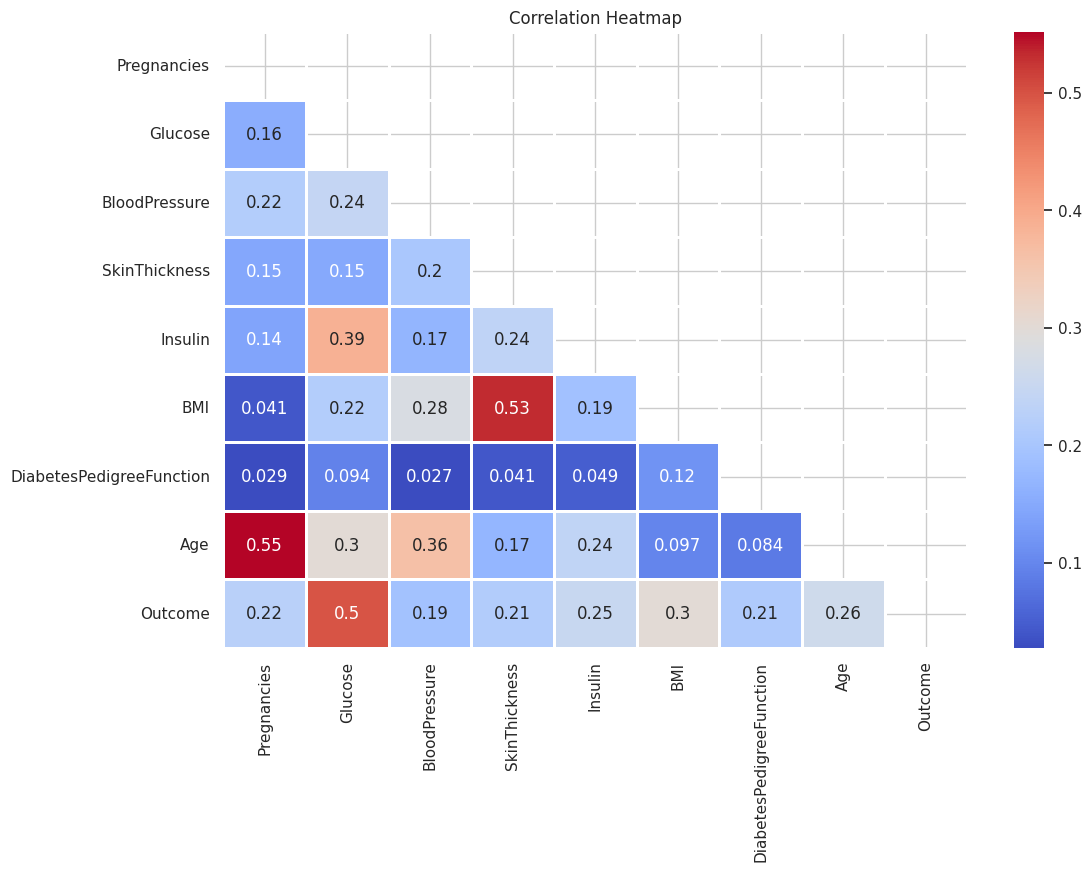

                 Model  Accuracy  Precision    Recall  F1-Score
0                 k-NN  0.757396   0.615385  0.603774  0.609524
1                  SVM  0.781065   0.666667  0.603774  0.633663
2  Logistic Regression  0.775148   0.659574  0.584906  0.620000


<ipython-input-9-904d4c3f7278>:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette="viridis")


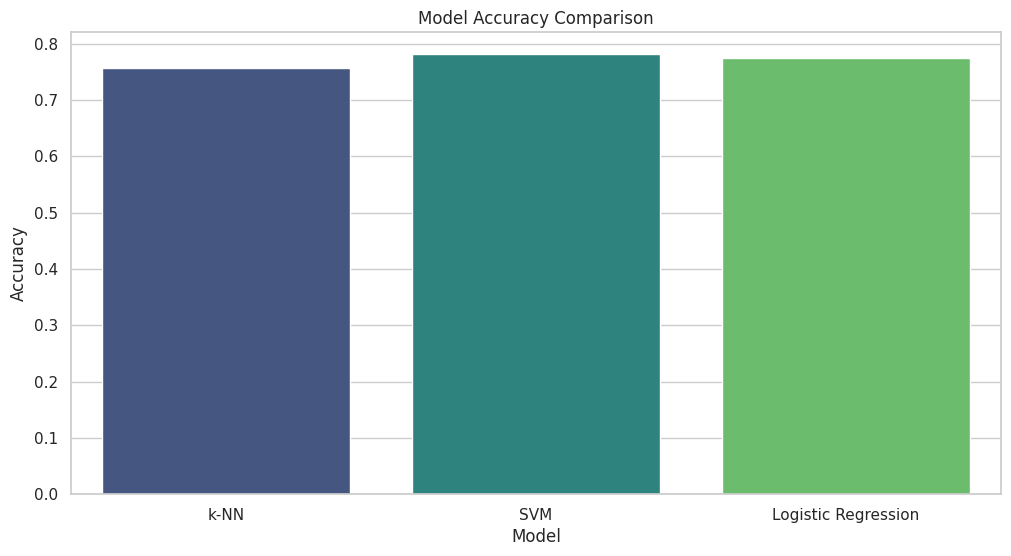

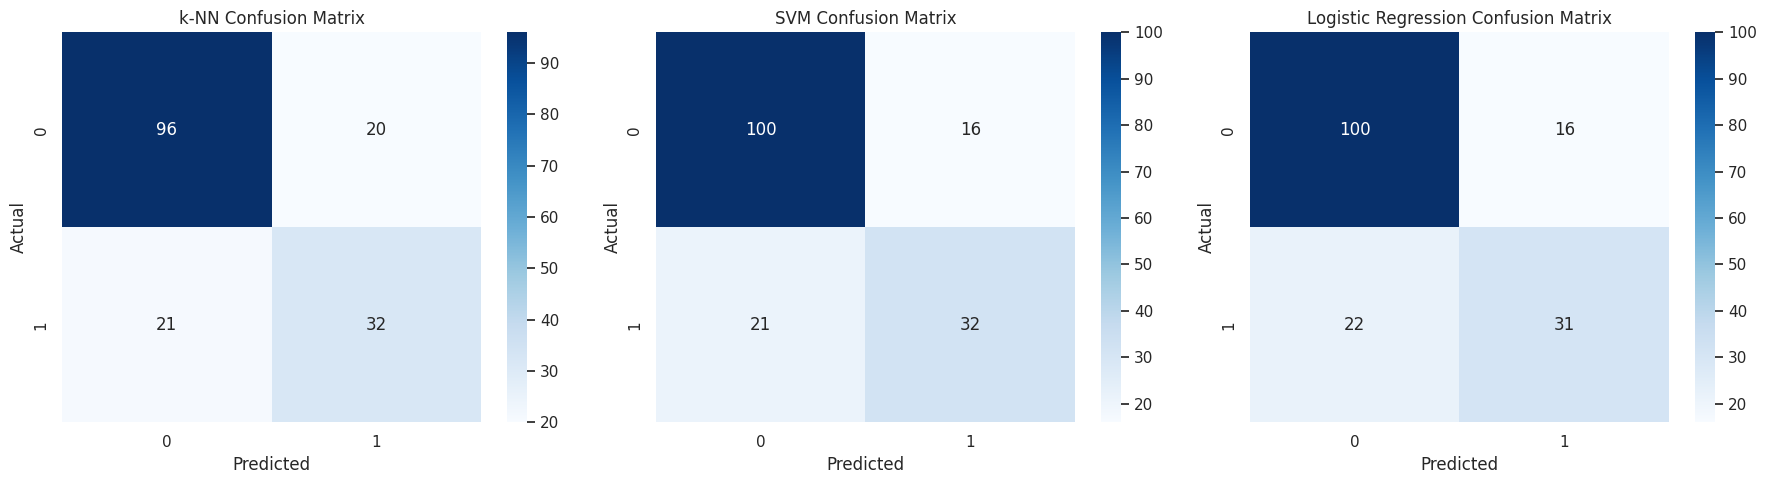

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

sns.set(style="whitegrid")

# Load data
data = pd.read_csv('/content/diabetes prediction dataset.csv')

# Handle missing or zero values dynamically
def replace_zeros(df, columns):
    for col in columns:
        mean_value = df[col][df[col] != 0].mean()
        df[col] = df[col].replace(0, mean_value)

replace_zeros(data, ['BMI', 'BloodPressure', 'Glucose', 'Insulin', 'SkinThickness'])

# Remove outliers dynamically
def remove_outliers(df, column, threshold):
    upper_limit = df[column].quantile(threshold)
    return df[df[column] < upper_limit]

outlier_columns = {
    'Pregnancies': 0.98,
    'BMI': 0.99,
    'SkinThickness': 0.99,
    'Insulin': 0.95,
    'DiabetesPedigreeFunction': 0.99,
    'Age': 0.99
}

for col, threshold in outlier_columns.items():
    data = remove_outliers(data, col, threshold)

# Visualize data distributions with histograms and boxplots
fig, axes = plt.subplots(len(data.columns), 2, figsize=(15, 40))
for i, column in enumerate(data.columns):
    sns.histplot(data[column], kde=True, color="blue", bins=20, ax=axes[i, 0])
    axes[i, 0].set_title(f"Distribution of {column}")
    sns.boxplot(data[column], color="green", ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot of {column}")
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap="coolwarm", fmt='.2g', linewidths=1)
plt.title("Correlation Heatmap")
plt.show()

# Prepare data
X = data.drop(columns=['Outcome'])
y = data['Outcome']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
knn = KNeighborsClassifier()
svm = SVC()
logistic = LogisticRegression()

# Hyperparameter tuning for k-NN
knn_params = {'n_neighbors': range(1, 31)}
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='accuracy')
knn_grid.fit(X_train, y_train)
best_knn = knn_grid.best_estimator_

# Hyperparameter tuning for SVM
svm_params = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy')
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_

# Train models
best_knn.fit(X_train, y_train)
best_svm.fit(X_train, y_train)
logistic.fit(X_train, y_train)

# Predictions
knn_y_pred = best_knn.predict(X_test)
svm_y_pred = best_svm.predict(X_test)
logistic_y_pred = logistic.predict(X_test)

# Evaluation metrics
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score'],
        'Confusion Matrix': cm
    }

results = []
results.append(evaluate_model(y_test, knn_y_pred, 'k-NN'))
results.append(evaluate_model(y_test, svm_y_pred, 'SVM'))
results.append(evaluate_model(y_test, logistic_y_pred, 'Logistic Regression'))

# Results summary
results_df = pd.DataFrame(results).drop(columns=['Confusion Matrix'])
print(results_df)

# Visualize results
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

# Confusion matrices visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models = ['k-NN', 'SVM', 'Logistic Regression']
for i, result in enumerate(results):
    sns.heatmap(result['Confusion Matrix'], annot=True, fmt='d', cmap="Blues", ax=axes[i])
    axes[i].set_title(f"{models[i]} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
plt.tight_layout()
plt.show()
